# Setting

In [1]:
from pf_utils import DataManager, FinancialRatios, BacktestManager, MomentumPortfolio
from pf_widgets import WidgetUniverse, WidgetTransaction

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
path_data = 'data'
path_tran = 'transaction'

*data for backtesting*

In [3]:
file_bt_price = 'kospi200_bt_prices_040102_241023.csv'
file_bt_ratio = 'kospi200_bt_ratios_040131_240930.csv'

# Data

## Price

In [4]:
file = 'kospi200_prices.csv'

*Uncomment for backtesting*

In [5]:
#file = file_bt_price

In [6]:
k200 = DataManager(
    universe = 'kospi200',
    file = file,
    path = path_data
)
k200.upload()

201 assets from 2021-01-04 to 2024-10-25 uploaded.
df_prices updated


In [7]:
df_k200 = k200.df_prices.ffill()
assetnames_k200 = k200.get_names()

## Ratios

In [8]:
WidgetUniverse

In [9]:
is_backtest = True if k200.file_historical == file_bt_price else False

In [10]:
file = 'kospi200_ratios.csv' if not is_backtest else file_bt_ratio
fr = FinancialRatios(file, path_data)

Financial ratios of 201 stocks from 2023-01-02 to 2024-10-25 loaded


In [11]:
start = '2023-01-01'
tickers = df_k200.columns.to_list()
kw = dict(
    freq = 'd',
    close_today = WidgetUniverse.values(1) 
)
fr.download(tickers, start, **kw) if not is_backtest and WidgetUniverse.values(0) else None

In [12]:
#fr.calc_rank(metrics='PER', date='start', topn=None)
fr.calc_rank(metrics='PER', topn=None)

Ranking score of PER on 2024-10-25


ticker
010060    0.000000
003030    0.006211
016380    0.012422
009970    0.018634
047040    0.024845
            ...   
009420    0.975155
329180    0.981366
377300    0.987578
450080    0.993789
004800    1.000000
Name: PER, Length: 162, dtype: float64

In [13]:
#fr.calc_historical()
fr.calc_historical(['PER', 'PBR'])

Historical of PER+PBR ranking score created


ticker  date      
005930  2023-01-02    1.115655
        2023-01-03    1.120757
        2023-01-04    1.146513
        2023-01-05    1.162310
        2023-01-06    1.167412
                        ...   
105630  2024-10-21    0.747569
        2024-10-22    0.731519
        2024-10-23    0.726519
        2024-10-24    0.755069
        2024-10-25    0.737044
Name: PER, Length: 88315, dtype: float64

In [14]:
#fr.get_stats(stats_daily=False)
fr.get_stats()

Returning stats of daily averages


,BPS,PER,PBR,EPS,DIV,DPS
start,2023-01-02,2023-01-02,2023-01-02,2023-01-02,2023-01-02,2023-01-02
end,2024-10-25,2024-10-25,2024-10-25,2024-10-25,2024-10-25,2024-10-25
mean,105856.3,69.9,2.3,8746.6,2.4,1815.7
std,3555.0,41.1,0.3,1367.9,0.1,122.3


## Reshape
Interpolate & Reshape for backtesting

In [15]:
df_p = fr.util_reshape(df_k200)

fratios_dict = dict()
for r in ['PER', 'PBR']:
    df = fr.interpolate(df_p, r)
    fratios_dict[r] = fr.util_reshape(df, stack=False)

# Backtest

## Example

In [16]:
fratio = 'PER'
df_ratio = fratios_dict[fratio]

In [17]:
kwargs_bm = dict(
    initial_capital = 1e8,
    commissions = 0,
    align_axis = None, 
    days_in_year = 246,
    asset_names = assetnames_k200
)
bm = BacktestManager(df_k200, **kwargs_bm)

201 assets from 2021-01-04 to 2024-10-25 uploaded.
running self.util_check_days_in_year to check days in a year


In [18]:
bm.benchmark_ticker()

Benchmark is KODEX200


In [19]:
#bm.buy_n_hold(name='PER', weigh='equally')

In [20]:
kwargs_build = dict(
    name=fratio, select='f-ratio', weigh='Equally', 
    n_assets=10, freq='Y', lookback=0,
    df_ratio=df_ratio, ratio_descending=False
)
bm.build(**kwargs_build)

Backtesting 2 strategies: KODEX200, PER


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.51it/s]

Returning stats


,PER,KODEX200
start,2021-01-03,2021-01-03
end,2024-10-25,2024-10-25
total_return,0.027597,-0.073832
cagr,0.007174,-0.019938
calmar,0.031739,-0.058094
max_drawdown,-0.226021,-0.343206
avg_drawdown,-0.035972,-0.087869
avg_drawdown_days,79.375,229.333333
daily_vol,0.158874,0.18087
daily_sharpe,0.125404,-0.023235


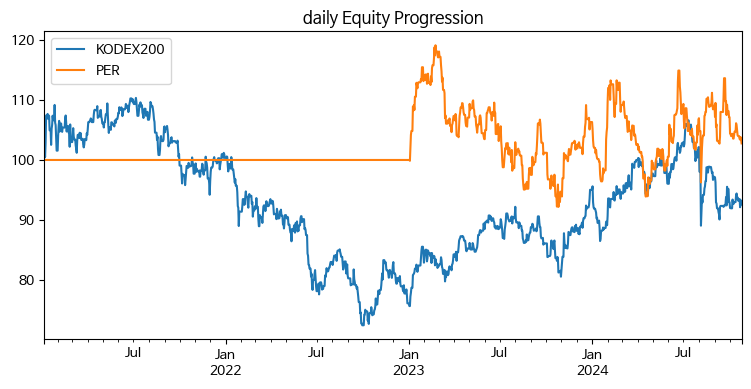

In [21]:
bm.run(figsize=(9,4), stats_sort_by='cagr')

In [22]:
bm.portfolios

0) KODEX200
1) PER

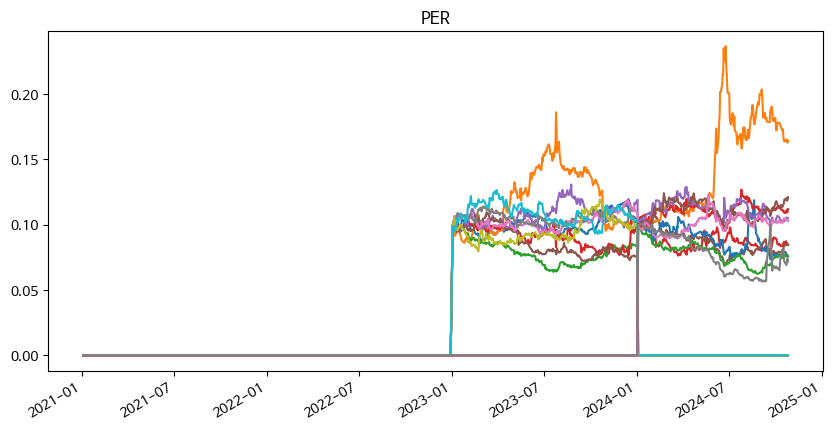

In [23]:
bm.plot_security_weights(1, legend=False)

## Parameter study

In [24]:
len(df_k200)

938

In [25]:
n_val = 400
lookback = 100
df = df_k200
df_train = df.iloc[:-n_val]
df_val = df.iloc[-n_val-lookback:]

In [26]:
kwargs_bm = dict(
    initial_capital = 1e8,
    commissions = 0,
    align_axis = None, 
    days_in_year = 246,
    asset_names = assetnames_k200
)

### Cross-validate

In [23]:
from itertools import product

p_args = dict(
    #p_fr = ['PER', 'PBR', 'PER+PBR'],
    p_fr = ['PER'],
    p_ast = [5, 10, 20, 30],
    p_freq = [130, 250, 500],
    p_lb = [0, 5, 10, 20, 30, 60] # days
)
p_comb = list(product(*p_args.values()))
params = [{'name':'{}:a{}/f{}/lb{}'.format(*x),
           'df_ratio':x[0], 'n_assets':x[1], 'freq':x[2], 'lookback':x[3]} 
          for x in p_comb]
params[0]

{'name': 'PER:a5/f130/lb0',
 'df_ratio': 'PER',
 'n_assets': 5,
 'freq': 130,
 'lookback': 0}

In [24]:
convert_args = lambda p: [{**x, 'df_ratio': fratios_dict[x['df_ratio']], 
                           'lookback':f'{x['lookback']} days'} for x in p]

In [25]:
bm = BacktestManager(df_train, **kwargs_bm)

426 assets from 2004-01-02 to 2023-03-03 uploaded.
running self.util_check_days_in_year to check days in a year


In [26]:
kwa_list = convert_args(params)

kwargs_build = dict(
    select='F-ratio', weigh='Equally', ratio_descending=False, build_cv=True
)
bm.build_batch(*kwa_list, **kwargs_build)

72 jobs prepared for cross-validation


In [28]:
kw_batch = dict(size_batch=9, path_batch=path_data)
bm.cross_validate(n_sample=20, **kw_batch)

Cross-validating 72 strategies: PER:a5/f130/lb0, PER:a5/f130/lb5, ... , PER:a30/f500/lb60


100%|███████████████████████████████████████████████████████████████| 19/19 [01:42<00:00,  5.41s/it]


115.1 mins elapsed, 0.0 secs paused (0.0%)


### Visualize

In [27]:
file = 'param_per_k2hl.csv'

*Save param study*

In [30]:
f = dict(file=file, path=path_data)
df_cv = bm.get_cat_data(params, **f)

data/param_per_k2hl.csv saved
72 param sets with 19 iterations per set


*Load param study*

In [28]:
bm = BacktestManager
df_cv = bm.catplot(file, path=path_data)

Returning data/param_per_k2hl.csv
72 param sets with 19 iterations per set


In [29]:
y = 'cagr'
ref_val = bm.benchmark_stats(y, data=df_cv)

Returning cagr of KODEX200 from 2004-01-02 to 2023-03-03


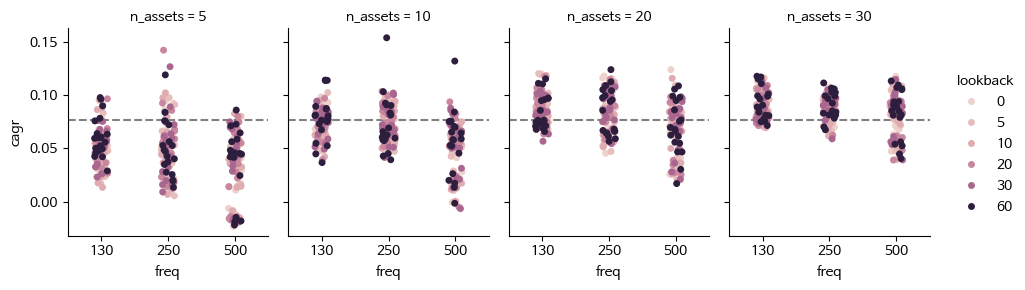

In [30]:
#kw = {'x':'lookback', 'row':'freq', 'col':'n_assets'}
#kw = {'hue':'lookback', 'col':'freq', 'x':'n_assets'}
#kw = {'col':'freq', 'x':'n_assets', 'kind':'box'}
#kw = {'x':'freq', 'col':'n_assets', 'kind':'box'}
kw = {'x':'freq', 'col':'n_assets', 'hue':'lookback'}

_ = bm.catplot(data=df_cv, y=y, ref_val=ref_val, height=3, aspect=.8, **kw)

### Validation

In [23]:
bm = BacktestManager(df_val, **kwargs_bm)

426 assets from 2022-10-11 to 2024-10-23 uploaded.
running self.util_check_days_in_year to check days in a year


In [24]:
bm.benchmark_ticker()

Benchmark is KODEX200


In [25]:
#p_comb = [[30, 130], [20, 130], [10, 130], [5, 130]]
p_comb = [[30, 250], [20, 250], [10, 250]]
kwa_list = [{'name':'PER:a{}/f{}'.format(*x), 'n_assets':x[0], 'freq':x[1]} for x in p_comb]

Backtesting 4 strategies: KODEX200, PER:a30/f250, PER:a20/f250, PER:a10/f250


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.63it/s]

Returning stats


,KODEX200,PER:a10/f250,PER:a20/f250,PER:a30/f250
start,2022-10-10,2022-10-10,2022-10-10,2022-10-10
end,2024-10-23,2024-10-23,2024-10-23,2024-10-23
total_return,0.274088,0.168539,0.101883,0.080747
cagr,0.126277,0.079463,0.048783,0.038858
calmar,0.766397,0.563673,0.369704,0.343622
max_drawdown,-0.164768,-0.140974,-0.131951,-0.113082
avg_drawdown,-0.030914,-0.038722,-0.023539,-0.025242
avg_drawdown_days,22.586207,46.066667,54.153846,70.6
daily_vol,0.182829,0.171644,0.120299,0.108617
daily_sharpe,0.759795,0.542939,0.466529,0.414565


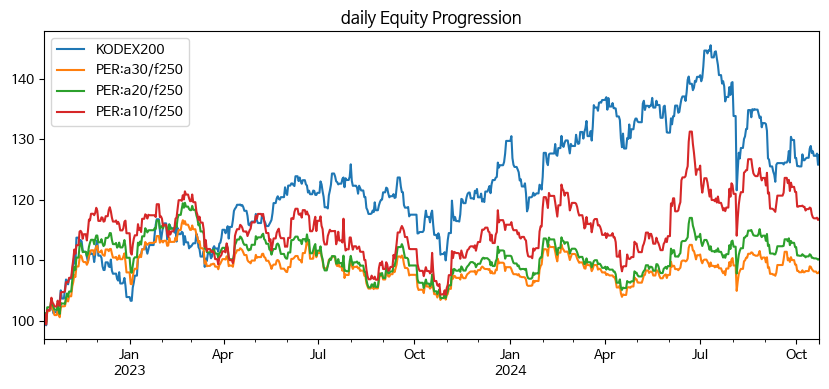

In [26]:
kwargs_build = dict(
    select='f-ratio', weigh='Equally', 
    ratio_descending=False, build_cv=False,
    df_ratio=fratios_dict['PER']
)
bm.build_batch(*kwa_list, **kwargs_build)

bm.run(stats_sort_by='cagr', figsize=(10,4))

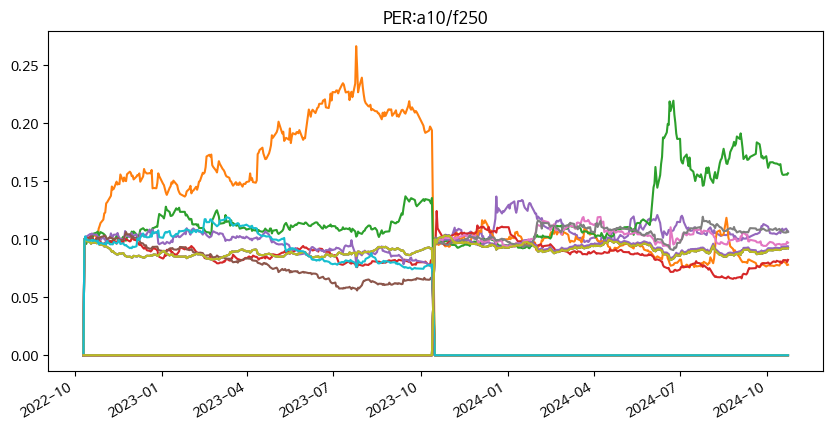

In [27]:
bm.plot_security_weights(3, legend=False)

# Transaction

In [63]:
fratio = 'PER'
df_ratio = fratios_dict[fratio]

In [64]:
kwargs = dict(
    name=fratio,
    #file='pf_k200_per.csv',
    file='test_per.csv',
    path=path_tran,
    days_in_year=246,
    asset_names=assetnames_k200,
    lookback='5 days', # days
    df_additional=df_ratio,
    method_weigh='equally',
)
kwargs.update(MomentumPortfolio.check_init_args(fratio))

pf_per = MomentumPortfolio(df_k200, **kwargs)

201 assets from 2021-01-04 to 2024-10-25 uploaded.
running self.util_check_days_in_year to check days in a year
REMINDER: make sure this is 1st transaction as no records provided


In [65]:
pf_per.view_record()

ERROR: No transaction record


In [66]:
pf_per.valuate()

ERROR: No transaction record


In [67]:
# set kwargs of transaction_pipeline
WidgetTransaction

In [68]:
kwargs_trs = dict(
    n_assets = 10,
    date = WidgetTransaction.values(0),
    capital = WidgetTransaction.values(1),
    save = WidgetTransaction.values(2)
)

_ = pf_per.transaction_pipeline(**kwargs_trs)
pf_per.view_record()

Liquidation set to None
10 assets selected by Financial Ratio from 2024-03-27 to 2024-04-01
Weights of assets determined by Equal weights.
Mean absolute error of weights: 2 %
Portfolio value 9,747,240, Profit -0.2% on 2024-10-25
Set save=True to save transaction record


name   price  transaction  net weight weight*
date       asset                                                    
2024-04-01 011200       HMM   15870           63   63  0.100  0.1023
           016380      KG스틸    7150          139  139  0.100  0.1017
           137310  에스디바이오센서   11930           83   83  0.100  0.1013
           036460    한국가스공사   26800           37   37  0.100  0.1015
           139480       이마트   69100           14   14  0.100  0.0990
           001120   LX인터내셔널   26700           37   37  0.100  0.1011
           000880        한화   27000           37   37  0.100  0.1022
           078930        GS   47800           20   20  0.100  0.0978
           000670        영풍  470500            2    2  0.100  0.0963
           009970   영원무역홀딩스   85800           11   11  0.100  0.0966

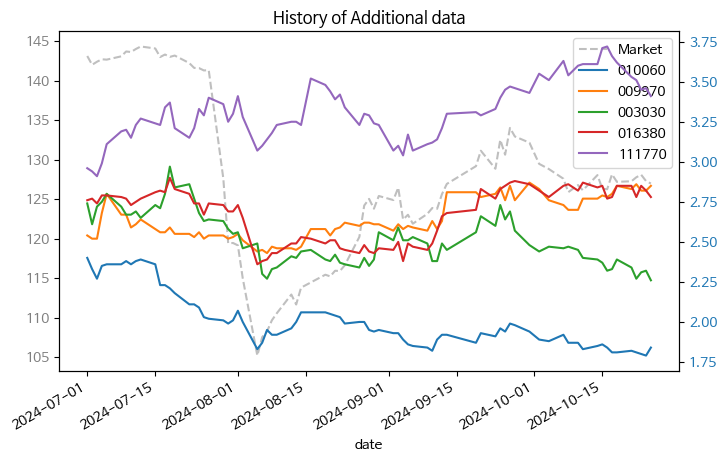

In [94]:
_ = pf_per.check_additional(plot=True)

In [59]:
df_k200['005010']

KeyError: '005010'

In [61]:
df_ratio

ticker,000020,000030,000050,000060,000070,000080,000100,000120,000140,000150,...,336260,352820,361610,373220,375500,377300,381970,383220,402340,450080
date,,,,,,,,,,,,,,,,,,,,,
2004-02-02,4.404583,NaN,NaN,NaN,2.719488,NaN,11.307168,NaN,15.858670,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-02-03,4.533750,NaN,NaN,NaN,2.726325,NaN,11.341329,NaN,16.035053,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-02-04,5.211875,NaN,NaN,NaN,2.808507,NaN,12.436177,NaN,16.211107,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-02-05,4.701667,NaN,NaN,NaN,2.835990,NaN,12.350775,NaN,15.946697,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-02-06,4.830833,NaN,NaN,NaN,2.835990,NaN,12.000629,NaN,15.259626,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-17,8.070000,7.4,0.0,8.95,3.250000,39.735455,83.187896,8.601815,229.020000,0.0,...,0.0,45.430284,27.397928,74.639831,7.445042,1302.687090,22.92,4.645693,0.0,942.835953
2024-10-18,8.070000,7.4,0.0,8.95,3.250000,39.636364,83.999222,8.718980,229.020000,0.0,...,0.0,44.649858,26.790884,73.041749,7.213109,1323.955451,22.92,4.722482,0.0,965.205523
2024-10-21,8.070000,7.4,0.0,8.95,3.250000,39.834545,86.541374,8.621343,229.020000,0.0,...,0.0,45.950569,26.305249,73.229759,7.317479,1382.443443,22.92,4.668730,0.0,961.063010
